In [1]:
import random
import pandas as pd
import numpy as np
import tensorflow as tf
import csv
from pathlib import Path

from sklearn import preprocessing
from tensorflow.keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from tensorflow.keras.layers import RepeatVector, Dense, Activation, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model, Model

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# TODO
# - Pathlib 
# - TF functionnal API



In [3]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.9.1


In [4]:
### META
# PATH
DATA_FOLDER = "./data"

# MODEL
EPOCHS = 5

In [5]:
train_df = pd.read_csv(DATA_FOLDER+"/train.csv", index_col="row_id")
test_df = pd.read_csv(DATA_FOLDER+"/test.csv", index_col="row_id")
train_df.info()
test_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 70128 entries, 0 to 70127
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      70128 non-null  object
 1   country   70128 non-null  object
 2   store     70128 non-null  object
 3   product   70128 non-null  object
 4   num_sold  70128 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 3.2+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 17520 entries, 70128 to 87647
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   date     17520 non-null  object
 1   country  17520 non-null  object
 2   store    17520 non-null  object
 3   product  17520 non-null  object
dtypes: object(4)
memory usage: 684.4+ KB


In [46]:
book_features = train_df.copy()

# is the date relevant in our case ? RNN
book_features.pop("date")

# What we want to predict
labels = "num_sold"
book_labels = book_features.pop(labels).astype(int)
book_features.info()

if "date" in book_features:
    book_features["date"] = pd.to_datetime(book_features["date"])
# not needed
#book_features["country"] = book_features["country"].astype("category")
#book_features["store"] = book_features["store"].astype("category")
#book_features["product"] = book_features["product"].astype("category")

book_features["country"] = pd.factorize(book_features["country"])[0]
book_features["store"] = pd.factorize(book_features["store"])[0]
book_features["product"] = pd.factorize(book_features["product"])[0]
book_features.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 70128 entries, 0 to 70127
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   country  70128 non-null  object
 1   store    70128 non-null  object
 2   product  70128 non-null  object
dtypes: object(3)
memory usage: 2.1+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 70128 entries, 0 to 70127
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   country  70128 non-null  int64
 1   store    70128 non-null  int64
 2   product  70128 non-null  int64
dtypes: int64(3)
memory usage: 2.1 MB


In [47]:
train_df

,date,country,store,product,num_sold
row_id,,,,,
0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240
...,...,...,...,...,...
70123,2020-12-31,Spain,KaggleMart,Kaggle for Kids: One Smart Goose,614
70124,2020-12-31,Spain,KaggleRama,Kaggle Advanced Techniques,215
70125,2020-12-31,Spain,KaggleRama,Kaggle Getting Started,158


In [48]:
book_features

,country,store,product
row_id,,,
0,0,0,0
1,0,0,1
2,0,0,2
3,0,0,3
4,0,1,0
...,...,...,...
70123,5,0,3
70124,5,1,0
70125,5,1,1


In [41]:
book_labels


row_id
0        663
1        615
2        480
3        710
4        240
        ... 
70123    614
70124    215
70125    158
70126    135
70127    202
Name: num_sold, Length: 70128, dtype: int64

In [42]:
class myCallback(tf.keras.callbacks.Callback):
        # Define the correct function signature for on_epoch_end
        def on_epoch_end(self, epoch, logs={}):
            accuracy = 0.99
            if logs.get('accuracy') is not None and logs.get('accuracy') > accuracy:
                print(f"\nReached {accuracy*100}% accuracy so cancelling training!") 
                
                # Stop training once the above condition is met
                self.model.stop_training = True

In [49]:
def book_model(x_train, y_train):
    
    # Instantiate the callback class
    callbacks = myCallback()
    
    model = tf.keras.Sequential([
        tf.keras.layers.Normalization(),
        tf.keras.layers.Dense(3, activation="relu"),
        tf.keras.layers.Dense(5, activation="relu"),
        tf.keras.layers.Dense(5, activation="relu"),
        tf.keras.layers.Dense(5, activation="relu"),
        tf.keras.layers.Dense(1, activation="relu"),
    ])

    model.compile(
        optimizer='sgd',#'adam',
        loss='mean_squared_error',
        metrics=['accuracy'],
    )

    history = model.fit(
        x_train, 
        y_train, 
        epochs=EPOCHS, 
        callbacks=[callbacks]
    )


    return model, history


In [50]:
model, history = book_model(book_features, book_labels)


Epoch 1/5
2192/2192 [==============================] - 3s 1ms/step - loss: 21227.2969 - accuracy: 0.0000e+00
Epoch 2/5
2192/2192 [==============================] - 3s 1ms/step - loss: 6013.9937 - accuracy: 0.0000e+00
Epoch 3/5
2192/2192 [==============================] - 3s 1ms/step - loss: 5946.5312 - accuracy: 0.0000e+00
Epoch 4/5
2192/2192 [==============================] - 3s 1ms/step - loss: 5944.5205 - accuracy: 0.0000e+00
Epoch 5/5
2192/2192 [==============================] - 3s 1ms/step - loss: 5941.9785 - accuracy: 0.0000e+00


KeyError: 'val_accuracy'

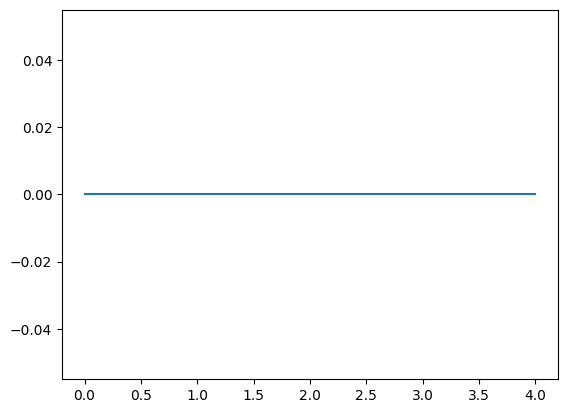

In [51]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")